This script gets the results from the following situation:
1. for each patient, there are several images
2. for each patient, we get the label of largest probability of several images
3. get the correct label for each patient
4. compute the AUC score for each patient

In [4]:
# torch
import torch
import torch.nn as nn

import numpy as np

# model 
from models.densenet121 import make_model

# project
from utils.config_utils import load_config
from utils.Timer import Timer

# system
import time
import pickle
import pandas as pd

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from skimage import io

import numpy as np
import pandas as pd

import torchvision
from torchvision import transforms

In [6]:
# transformation for training and validation
# we use 364 is according to ImageNet: (364 / 320) = (256 / 224)
# we use horizontal flip since maybe the lateral pictures have different views
# either from left or from right
train_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364, 364]),
        transforms.RandomResizedCrop(320),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([364,364]),
        transforms.CenterCrop(320),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [7]:
class CheXpertEvalDataset(Dataset):
    """
    Customized dataset for CheXpert dataset (https://stanfordmlgroup.github.io/competitions/chexpert/)
    """
    def __init__(self, csv_file, image_root_dir, transform=None):
        """
        Args:
            - csv_file: path to trainining and validation csv file, like "./data/CheXpert-v1.0-small/train_preprocessed.csv"
            - image_root_dir: root_dir containing image path in the csv file, like "./data/"
            - transform: transformation for each image
        """
        # for the basic ones
        self.data_frame = pd.read_csv(csv_file)
        self.image_root_dir = image_root_dir
        self.image_path = self.data_frame["Path"]
        self.patientid = self.data_frame["patientID"]
        
        # for the transformation
        self.transform = transform
        
        def __len__(self):
            return len(self.data_frame)
    
    def __getitem__(self, index):
        # to read in the image
        image_filename = self.image_root_dir + self.image_path[index]
        image = io.imread(image_filename, as_gray=True)
        
        # sample is a dictionary which includes the image and 14 labels
        sample = {}
        
        # since the input to pre-trained network should have 3 channels
        # we need to pad it with two repeatition
        image = np.repeat(image[None,...], 3, axis=0).transpose(1,2,0)
        
        # transform the image if transform is not None
        if self.transform:
            image = self.transform(image)
            
        # add image into the sample dictionary
        sample["image"] = image
        
        # add patientID into the sample dictionary
        sample["patientID"] = self.patientid[index]
        
        # get the label for the image
        label_col_names = ["No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Opacity", 
                           "Lung Lesion", "Edema", "Consolidation", "Pneumonia", "Atelectasis",
                           "Pneumothorax", "Pleural Effusion", "Pleural Other", "Fracture", "Support Devices"]
        
        # to get the label for each column
        # 0 --> negative
        # 1 --> positive
        # 2 --> uncertainty (No Finding has no 2)
        for label in label_col_names:
            if self.data_frame[label][index] == 0.0:
                sample[label] = torch.LongTensor([0])
            elif self.data_frame[label][index] == 1.0:
                sample[label] = torch.LongTensor([1])
            else:
                sample[label] = torch.LongTensor([2])
        
        return sample

In [8]:
eval_dataset = CheXpertEvalDataset(csv_file="./valid_patientid.csv", image_root_dir="../data/", transform=validation_transform)
data_sample = eval_dataset.__getitem__(0)

In [9]:
data_sample["image"].shape

torch.Size([3, 320, 320])

In [10]:
def evaluation(sample_dict, model, device):
    """
    Args:
        - sample_dict: the dictionary containing the evaluation sample
        - model: deep learning model we want to evaluation
        - device: cpu or gpu
    Returns:
        - result_dict: classification results for the sample
    """
    # intialize the environment
    model.eval()
    
    # Note here we don't need to keep track of gradients
    with torch.no_grad():
        
        softmax = nn.Softmax(dim=1)
        # the output of the dataloader is a dictionary containing batch of images
        # and corresponding 14 labels
        # image is a uint8 tensor (convert to float!!) of shape [batch_size, 3, 320, 320]
        # each label is a nn.LongTensor type tensor of shape (batch_size, 1) (need to squeeze)
        # for each label: Here, in each one-hot vector: 
        # the first element is negative (0.0), 
        # the second element is positive (1.0) 
        # and the last one is uncertainty (-1.0).
        image = sample_dict["image"].unsqueeze(0).float().to(device)
        
        # input all the input vectors into the model
        # the output dimension is [batch_size, 41]
        preds = model(image)
        
        # get the classification results for this sample
        # Note here, what is different is that we only use first two labels (negative and positive)
        # and get the maximum between them
        # here, since we need to get the probability, we need to use softmax to get the real probability  
        prob_no_finding, preds_no_finding = torch.max(softmax(preds[:, :2]), dim=1)
        prob_en_card, preds_en_card = torch.max(softmax(preds[:, 2:4]), dim=1)
        prob_card, preds_card = torch.max(softmax(preds[:, 5:7]), dim=1) 
        prob_lung_op, preds_lung_op = torch.max(softmax(preds[:, 8:10]), dim=1) 
        prob_lung_le, preds_lung_le = torch.max(softmax(preds[:, 11:13]), dim=1)
        prob_edema, preds_edema = torch.max(softmax(preds[:, 14:16]), dim=1)
        prob_cons, preds_cons = torch.max(softmax(preds[:, 17:19]), dim=1)
        prob_pneu, preds_pneu = torch.max(softmax(preds[:, 20:22]), dim=1)
        prob_atelec, preds_atelec = torch.max(softmax(preds[:, 23:25]), dim=1)
        prob_pneurax, preds_pneurax = torch.max(softmax(preds[:, 26:28]), dim=1) 
        prob_ple_eff, preds_ple_eff = torch.max(softmax(preds[:, 29:31]), dim=1)
        prob_ple_other, preds_ple_other = torch.max(softmax(preds[:, 32:34]), dim=1) 
        prob_frac, preds_frac = torch.max(softmax(preds[:, 35:37]), dim=1)
        prob_sup_dev, preds_sup_dev = torch.max(softmax(preds[:, 38:40]), dim=1)
        
        # construct a dictionary to contain the predictive probability
        pred_prob_dict = {"No Finding" : prob_no_finding.cpu().item(), 
                       "Enlarged Cardiomediastinum" : prob_en_card.cpu().item(), 
                       "Cardiomegaly" : prob_card.cpu().item(),
                       "Lung Opacity" : prob_lung_op.cpu().item(),
                       "Lung Lesion" : prob_lung_le.cpu().item(),
                       "Edema" : prob_edema.cpu().item(),
                       "Consolidation" : prob_cons.cpu().item(),
                       "Pneumonia" : prob_pneu.cpu().item(),
                       "Atelectasis" : prob_atelec.cpu().item(),
                       "Pneumothorax" : prob_pneurax.cpu().item(),
                       "Pleural Effusion" : prob_ple_eff.cpu().item(),
                       "Pleural Other" : prob_ple_other.cpu().item(),
                       "Fracture" : prob_frac.cpu().item(),
                       "Support Devices" : prob_sup_dev.cpu().item()}
        
        pred_label_dict = {"No Finding" : preds_no_finding.cpu().item(), 
                       "Enlarged Cardiomediastinum" :preds_en_card.cpu().item(), 
                       "Cardiomegaly" : preds_card.cpu().item(),
                       "Lung Opacity" : preds_lung_op.cpu().item(),
                       "Lung Lesion" : preds_lung_le.cpu().item(),
                       "Edema" : preds_edema.cpu().item(),
                       "Consolidation" : preds_cons.cpu().item(),
                       "Pneumonia" : preds_pneu.cpu().item(),
                       "Atelectasis" : preds_atelec.cpu().item(),
                       "Pneumothorax" : preds_pneurax.cpu().item(),
                       "Pleural Effusion" : preds_ple_eff.cpu().item(),
                       "Pleural Other" : preds_ple_other.cpu().item(),
                       "Fracture" : preds_frac.cpu().item(),
                       "Support Devices" : preds_sup_dev.cpu().item()} 
        
        return pred_prob_dict, pred_label_dict

In [242]:
# test
params = load_config('config.yaml')
model = make_model(pretrained=params['pretrained'])
PATH_pretrained = "./models/session_2019-05-05[22_03_43]/model_1.pth"
model.load_state_dict(torch.load(PATH_pretrained))

/scratch/hw1666/final_projects/dl4med_correct/CheXpert_epoch_10/utils/config_utils.py:7: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [243]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplac

In [244]:
pred_prob_dict, pred_label_dict = evaluation(data_sample, model, device)

# Get all labels and corresponding probability

In [245]:
with open("./valid_patientid.csv", "rt") as fin:
    valid_set = pd.read_csv(fin)

In [246]:
patients_detection_results = {}  # construct a dictionary storing the diagnose result for ALL patients from different images
# for each patient
for num, patient in enumerate(pd.unique(valid_set["patientID"])):
    #if num == 1:
    #    break
    patient_records = valid_set.loc[valid_set["patientID"]==patient]
    
    patient_results = {} # the dictionary storing the label and the corresponding probabilty 
    
    patient_prob_results = {'No Finding': [],
                       'Enlarged Cardiomediastinum': [],
                       'Cardiomegaly': [],
                       'Lung Opacity': [],
                       'Lung Lesion': [],
                       'Edema': [],
                       'Consolidation': [],
                       'Pneumonia': [],
                       'Atelectasis': [],
                       'Pneumothorax': [],
                       'Pleural Effusion': [],
                       'Pleural Other': [],
                       'Fracture': [],
                       'Support Devices': []}  # a dictionary storing the diagnose probability result for ONE patient
    
    patient_label_results = {'No Finding': [],
                       'Enlarged Cardiomediastinum': [],
                       'Cardiomegaly': [],
                       'Lung Opacity': [],
                       'Lung Lesion': [],
                       'Edema': [],
                       'Consolidation': [],
                       'Pneumonia': [],
                       'Atelectasis': [],
                       'Pneumothorax': [],
                       'Pleural Effusion': [],
                       'Pleural Other': [],
                       'Fracture': [],
                       'Support Devices': []}  # a dictionary storing the diagnose labels result for ONE patient
    
    # for each image
    for index in patient_records.index:
        data_sample = eval_dataset.__getitem__(index)
        pred_prob_dict, pred_label_dict = evaluation(data_sample, model, device)
        # for each disease
        for disease, prob in pred_prob_dict.items():
            patient_prob_results[disease].append(prob)
        for disease, label in pred_label_dict.items():
            patient_label_results[disease].append(label)
            
    #print(patient_prob_results)
    #print(patient_label_results)
            
    # take the largest probability and the corresponding label
    for disease, probs in patient_prob_results.items():
        # get the max probability
        max_prob = max(probs)
        # get the index of it
        for index, prob in enumerate(probs):
            if prob == max_prob:
                break
        patient_results[disease] = (patient_label_results[disease][index], max_prob)
    
    # store the ONE patient result into ALL patients result
    patients_detection_results[patient] = patient_results

In [247]:
patients_detection_results

{'patient64541': {'No Finding': (0, 0.615227997303009),
  'Enlarged Cardiomediastinum': (1, 0.5202333927154541),
  'Cardiomegaly': (0, 0.6146897077560425),
  'Lung Opacity': (0, 0.5888063907623291),
  'Lung Lesion': (0, 0.7157318592071533),
  'Edema': (0, 0.6247830986976624),
  'Consolidation': (0, 0.7597567439079285),
  'Pneumonia': (0, 0.8397445678710938),
  'Atelectasis': (1, 0.5790748000144958),
  'Pneumothorax': (0, 0.6583911776542664),
  'Pleural Effusion': (0, 0.8291051983833313),
  'Pleural Other': (0, 0.9332242608070374),
  'Fracture': (1, 0.5167950987815857),
  'Support Devices': (0, 0.63818359375)},
 'patient64542': {'No Finding': (1, 0.8929703235626221),
  'Enlarged Cardiomediastinum': (0, 0.7431185841560364),
  'Cardiomegaly': (0, 0.9502152800559998),
  'Lung Opacity': (0, 0.8938822746276855),
  'Lung Lesion': (1, 0.6110826730728149),
  'Edema': (0, 0.9916307330131531),
  'Consolidation': (0, 0.8942960500717163),
  'Pneumonia': (0, 0.8657388091087341),
  'Atelectasis': (0,

# To get the labels and corresponding probability lists

In [248]:
all_patients_label_lists = {'No Finding': [],
                       'Enlarged Cardiomediastinum': [],
                       'Cardiomegaly': [],
                       'Lung Opacity': [],
                       'Lung Lesion': [],
                       'Edema': [],
                       'Consolidation': [],
                       'Pneumonia': [],
                       'Atelectasis': [],
                       'Pneumothorax': [],
                       'Pleural Effusion': [],
                       'Pleural Other': [],
                       'Fracture': [],
                       'Support Devices': []}

all_patients_prob_lists = {'No Finding': [],
                       'Enlarged Cardiomediastinum': [],
                       'Cardiomegaly': [],
                       'Lung Opacity': [],
                       'Lung Lesion': [],
                       'Edema': [],
                       'Consolidation': [],
                       'Pneumonia': [],
                       'Atelectasis': [],
                       'Pneumothorax': [],
                       'Pleural Effusion': [],
                       'Pleural Other': [],
                       'Fracture': [],
                       'Support Devices': []}

In [249]:
for patient, results in patients_detection_results.items():
    for disease, (label, prob) in results.items():
        all_patients_label_lists[disease].append(label)
        if label == 0:
            all_patients_prob_lists[disease].append(1.0 - prob)
        else:
            all_patients_prob_lists[disease].append(prob)

In [250]:
all_patients_prob_lists

{'No Finding': [0.38477200269699097,
  0.8929703235626221,
  0.17004549503326416,
  0.9007975459098816,
  0.09323573112487793,
  0.09285938739776611,
  0.6920320391654968,
  0.07012611627578735,
  0.5101079344749451,
  0.7171200513839722,
  0.7405877113342285,
  0.007736563682556152,
  0.5514450669288635,
  0.7223312258720398,
  0.08869361877441406,
  0.6517152786254883,
  0.12079375982284546,
  0.8689659237861633,
  0.774134635925293,
  0.2887989282608032,
  0.609420657157898,
  0.8867600560188293,
  0.6075513958930969,
  0.3347700238227844,
  0.13703519105911255,
  0.7946237921714783,
  0.8048872947692871,
  0.8351514935493469,
  0.4892462491989136,
  0.26171231269836426,
  0.07318401336669922,
  0.8809725046157837,
  0.048397839069366455,
  0.6048755049705505,
  0.7871242761611938,
  0.7957767844200134,
  0.05132126808166504,
  0.6518610119819641,
  0.3038675785064697,
  0.010258793830871582,
  0.6921549439430237,
  0.1060895323753357,
  0.1938883662223816,
  0.8144076466560364,
  0

# To get the correct label for each disease

In [251]:
# to get the true labels
true_label_filename = "/scratch/hw1666/final_projects/dl4med/ablation_study/no_lateral_views/CheXpert_no_lateral_views/evaluation_results/correct_labels.pkl"
with open(true_label_filename, "rb") as fin:
    true_labels_dict = pickle.load(fin)

In [252]:
true_labels_dict

{'patient64541': {'No Finding': 0,
  'Enlarged Cardiomediastinum': 1,
  'Cardiomegaly': 1,
  'Lung Opacity': 1,
  'Lung Lesion': 0,
  'Edema': 0,
  'Consolidation': 0,
  'Pneumonia': 0,
  'Atelectasis': 0,
  'Pneumothorax': 0,
  'Pleural Effusion': 0,
  'Pleural Other': 0,
  'Fracture': 0,
  'Support Devices': 0},
 'patient64542': {'No Finding': 0,
  'Enlarged Cardiomediastinum': 0,
  'Cardiomegaly': 0,
  'Lung Opacity': 0,
  'Lung Lesion': 0,
  'Edema': 0,
  'Consolidation': 0,
  'Pneumonia': 0,
  'Atelectasis': 0,
  'Pneumothorax': 0,
  'Pleural Effusion': 0,
  'Pleural Other': 0,
  'Fracture': 0,
  'Support Devices': 1},
 'patient64543': {'No Finding': 0,
  'Enlarged Cardiomediastinum': 1,
  'Cardiomegaly': 0,
  'Lung Opacity': 1,
  'Lung Lesion': 0,
  'Edema': 1,
  'Consolidation': 0,
  'Pneumonia': 0,
  'Atelectasis': 0,
  'Pneumothorax': 0,
  'Pleural Effusion': 0,
  'Pleural Other': 0,
  'Fracture': 0,
  'Support Devices': 0},
 'patient64544': {'No Finding': 1,
  'Enlarged Cardi

In [253]:
all_patients_correct_label_lists = {'No Finding': [],
                       'Enlarged Cardiomediastinum': [],
                       'Cardiomegaly': [],
                       'Lung Opacity': [],
                       'Lung Lesion': [],
                       'Edema': [],
                       'Consolidation': [],
                       'Pneumonia': [],
                       'Atelectasis': [],
                       'Pneumothorax': [],
                       'Pleural Effusion': [],
                       'Pleural Other': [],
                       'Fracture': [],
                       'Support Devices': []}

for patient, results in true_labels_dict.items():
    for disease, label in results.items():
        all_patients_correct_label_lists[disease].append(label)

In [254]:
#all_patients_correct_label_lists

# Compute the AUC score for each disease

In [255]:
from sklearn.metrics import roc_auc_score

In [256]:
for disease, labels_list in all_patients_correct_label_lists.items():
    if disease == "Fracture":
        continue
    print(disease, "AUC: ", roc_auc_score(np.array(labels_list), np.array(all_patients_prob_lists[disease])), "\n")

No Finding AUC:  0.9151193633952255 

Enlarged Cardiomediastinum AUC:  0.6346867167919801 

Cardiomegaly AUC:  0.8110583446404342 

Lung Opacity AUC:  0.8872126436781609 

Lung Lesion AUC:  0.04020100502512558 

Edema AUC:  0.9041591320072333 

Consolidation AUC:  0.8612351190476191 

Pneumonia AUC:  0.5240885416666666 

Atelectasis AUC:  0.7666133333333334 

Pneumothorax AUC:  0.897766323024055 

Pleural Effusion AUC:  0.9024586397058822 

Pleural Other AUC:  0.6884422110552764 

Support Devices AUC:  0.7624762476247624 



In [257]:
import matplotlib.pyplot as plt
import scikitplot as skplt

In [286]:
drawing_disease = "Pneumothorax"

# Draw Confusion Matrix

In [287]:
predictive_labels = all_patients_label_lists[drawing_disease]
true_labels = all_patients_correct_label_lists[drawing_disease]

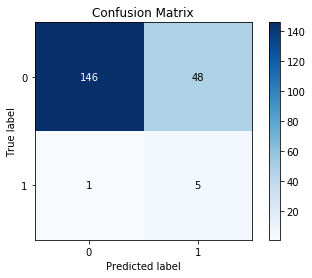

In [288]:
skplt.metrics.plot_confusion_matrix(true_labels, predictive_labels)
plt.show()

# Draw ROC curve

In [289]:
predictive_positive_prob = np.array(all_patients_prob_lists[drawing_disease])[..., None]
true_labels = np.array(all_patients_correct_label_lists[drawing_disease])

In [290]:
predictive_prob = np.concatenate((1-predictive_positive_prob,predictive_positive_prob),axis=1)

In [291]:
predictive_prob.shape

(200, 2)

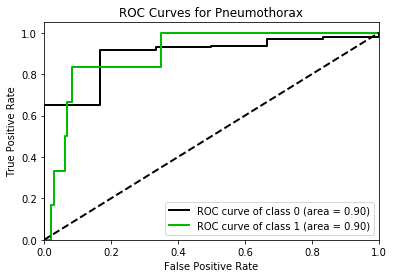

In [292]:
skplt.metrics.plot_roc(true_labels, predictive_prob, plot_micro=False, plot_macro=False, title="ROC Curves for "+drawing_disease)
plt.legend(loc="best")
plt.show()

In [293]:
(0.9151+0.6347+0.8111+0.9070+0.4020+0.9042+0.8943+0.7383+0.8115+0.8978+0.9287+0.9799+0.8828)/12


0.8236461538461538